# Monthly Flight Passengers Prediction using LSTM

Long Short-Term  Memory(LSTM) model on total passengers forecasting using time-series data. This dataset provides data from 1949 January.

# Dataset Description

The dataset is taken from the direct download of seaborn built in 'flight dataset'. The dataset has three columns: year, month, and passengers. The passengers column contains the total number of traveling passengers in a specified month. 

In [1]:
#import all the libraries that are needed
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from sklearn.preprocessing import MinMaxScaler

In [2]:
#vizualize the datasets in seaborn
sns.get_dataset_names()

C:\Users\prade\Anaconda3\envs\Python3.7\lib\site-packages\seaborn\utils.py:384: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 384 of the file C:\Users\prade\Anaconda3\envs\Python3.7\lib\site-packages\seaborn\utils.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

# 1. Loading & Vizualizing Flight Passengers Dataset 

In [3]:
#loading the dataset
flight_dataset = sns.load_dataset('flights')

In [4]:
#To vizualize the loaded dataset
flight_dataset

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
...,...,...,...
139,1960,August,606
140,1960,September,508
141,1960,October,461
142,1960,November,390


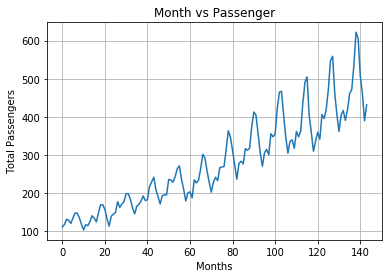

In [5]:
#plotting the data
plt.plot(flight_dataset['passengers'])
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)

# 2. Splitting the Dataset into Train, Test

In [6]:
#change the values of passengers to float values for prcoessing further
passenger_values = flight_dataset['passengers'].values.astype(float)

#train, test splitting the dataset train = (0,132) test = (132,144)
split_size = 12
train_values = passenger_values[:-split_size]
test_values = passenger_values[-split_size:]

In [10]:
#to evaluate oor normalize the values between -1 and 1
mm_scaler = MinMaxScaler(feature_range=(-1, 1)) 
mm_scaler = mm_scaler.fit(np.expand_dims(train_values, axis=1))
train_data = mm_scaler.transform(np.expand_dims(train_values, axis=1))
train_data.shape, train_data[0:5]

((132, 1),
 array([[-0.96483516],
        [-0.93846154],
        [-0.87692308],
        [-0.89010989],
        [-0.92527473]]))

# 3. Convert the Data into X,y

In [11]:
#These created train and test data should be split the sequence into input (X) and output (y) values depending on sequence length
def split_sequences(sequences_data,sequence_length):
    X,y = list(),list()
    for i in range(len(sequences_data)-sequence_length-1):
        # find the end of this pattern
        end_ix = i + sequence_length
        #gather input and output parts of the pattern
        seq_x, seq_y = sequences_data[i:(end_ix)],sequences_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
#Obtaining X and y values of train data
X_train, y_train = split_sequences(sequences_data=train_data,sequence_length = 12)

In [13]:
#Viewing first element of input train value
X_train[0], X_train.shape

(array([[-0.96483516],
        [-0.93846154],
        [-0.87692308],
        [-0.89010989],
        [-0.92527473],
        [-0.86373626],
        [-0.80659341],
        [-0.80659341],
        [-0.85934066],
        [-0.93406593],
        [-1.        ],
        [-0.93846154]]),
 (119, 12, 1))

In [14]:
#reshaping to required
X_train = X_train.reshape(len(X_train),12)
X_train[0], X_train.shape

(array([-0.96483516, -0.93846154, -0.87692308, -0.89010989, -0.92527473,
        -0.86373626, -0.80659341, -0.80659341, -0.85934066, -0.93406593,
        -1.        , -0.93846154]),
 (119, 12))

In [15]:
#Viewing first element of output train value
y_train[0], y_train.shape

(array([-0.95164835]), (119, 1))

In [16]:
#Converting train data from numpy array into Pytorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_train.shape, y_train.shape

(torch.Size([119, 12]), torch.Size([119, 1]))

# 4. Building LSTM Network Model
Initialise the data layers for the LSTM, sequence length, hidden and feature size. As it is require to reset the state after every epoch of turn to analyse again the data as clear. Get the test data time step that is required and sent to linear layer to forecast the future.

In [17]:
#Defining a class of future data prediction using 'LSTM' as of self.lstm
class FutureDataPrediction(nn.Module):
    def __init__(self, feature_size, hidden_layer):
        super(FutureDataPrediction, self).__init__()
        self.hidden_layer = hidden_layer
        
        self.lstm = nn.LSTM(input_size=feature_size,hidden_size=hidden_layer)
        self.linear = nn.Linear(in_features=hidden_layer, out_features=1)
        self.hidden = (
            torch.zeros(1,1, self.hidden_layer),
            torch.zeros(1,1,self.hidden_layer))
    
    def forward(self, data):
        lstm, self.hidden = self.lstm(data.view(len(data), 1, -1),self.hidden)
        previous_time_step = lstm.view(len(data), -1)
        out = self.linear(previous_time_step)
        return out[-1]
   

In [18]:
class FutureDataPrediction(nn.Module):
    def __init__(self, feature_size, hidden_layer, seq_len):
        super(FutureDataPrediction, self).__init__()
        self.hidden_layer = hidden_layer
        self.seq_len = seq_len
        
        
        self.lstm = nn.LSTM(input_size=feature_size,hidden_size=hidden_layer)
        self.linear = nn.Linear(in_features=hidden_layer, out_features=1)
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(1, self.seq_len, self.hidden_layer),
            torch.zeros(1, self.seq_len, self.hidden_layer))
    
    def forward(self, data):
        lstm, self.hidden = self.lstm(data.view(len(data), self.seq_len, -1),self.hidden)
        previous_time_step = lstm.view(self.seq_len, len(data), self.hidden_layer)[-1]
        out = self.linear(previous_time_step)
        return out
   

In [19]:
#initialise modelparameters
model = FutureDataPrediction(
    feature_size=1,
    hidden_layer=100,
    seq_len=12)
criterion = torch.nn.MSELoss() #loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #optimizer
model

FutureDataPrediction(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [20]:
#The designed model structure can be vizualized
torch.save(model.state_dict(), 'LSTM_Model.pt') #saving the model
model.load_state_dict(torch.load('LSTM_Model.pt')) #loading the model

<All keys matched successfully>

# 5. Train the LSTM Model using Hyperparameters

In [21]:
#defining train section of the model to attain the best predictions
def training(model,X_train,y_train,n_epochs):
    model.train()
    train_losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        model.reset_hidden_state() #the state has to be initialise to the start position after an epoch start.
        y_pred = model(X_train)
        loss = criterion(y_pred.float(), y_train) #attain loss to update weights.
        train_losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch} train loss: {loss.item()}')
            
        loss.backward()
        optimizer.step()
    return train_losses

In [22]:
train_losses = training(model,X_train,y_train,n_epochs=400)

Epoch 0 train loss: 0.21267318725585938
Epoch 10 train loss: 0.20088647305965424
Epoch 20 train loss: 0.19846759736537933
Epoch 30 train loss: 0.19646893441677094
Epoch 40 train loss: 0.1919783055782318
Epoch 50 train loss: 0.19963619112968445
Epoch 60 train loss: 0.20208550989627838
Epoch 70 train loss: 0.1981368064880371
Epoch 80 train loss: 0.1955859661102295
Epoch 90 train loss: 0.19487321376800537
Epoch 100 train loss: 0.19474875926971436
Epoch 110 train loss: 0.19451884925365448
Epoch 120 train loss: 0.19426177442073822
Epoch 130 train loss: 0.19403176009655
Epoch 140 train loss: 0.1937917172908783
Epoch 150 train loss: 0.19352862238883972
Epoch 160 train loss: 0.19323240220546722
Epoch 170 train loss: 0.1928723007440567
Epoch 180 train loss: 0.1923774927854538
Epoch 190 train loss: 0.19153599441051483
Epoch 200 train loss: 0.18903903663158417
Epoch 210 train loss: 0.1665409952402115
Epoch 220 train loss: 0.13727155327796936
Epoch 230 train loss: 0.12740761041641235
Epoch 240 tra

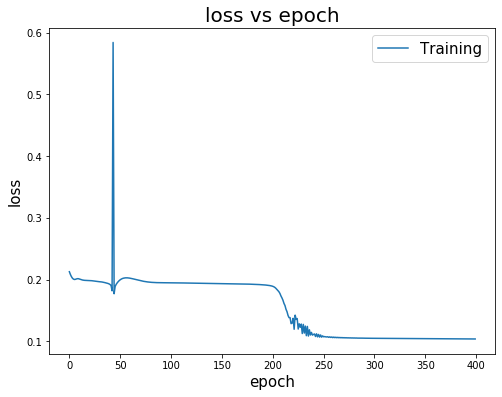

In [23]:
# Plotting loss values
'loss values during training for each epoch calculation'
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training')    
plt.title("loss vs epoch",fontsize=20)
plt.xlabel("epoch",fontsize=15)
plt.ylabel("loss",fontsize=15)
plt.legend(fontsize=15)
plt.show()

# 6. Validating Test Dataset by the LSTM Model
The data points are chosen as 12 because the train has 132 elements resulting total dataset elements as 144.

In [24]:
#Predicting data of future months
future_months = 12 #as the test data remainded is 12
sequence_length = 12
test_data = torch.FloatTensor(train_data[-sequence_length:].tolist()).reshape(1,12,1)
test_data.shape, test_data #defines next 12 months data i.e. indices: [133,134....144]

(torch.Size([1, 12, 1]),
 tensor([[[0.1253],
          [0.0462],
          [0.3275],
          [0.2835],
          [0.3890],
          [0.6176],
          [0.9516],
          [1.0000],
          [0.5780],
          [0.3319],
          [0.1341],
          [0.3231]]]))

In [25]:
#validating values for the test data for future prediction
def testing(model,test_data,predict_days,sequence_length):
    model.eval()
    with torch.no_grad():
        test_sequence = test_data #to send the last data of X as input to network to predict future
        predicts = []

        for _ in range(predict_days):
            y_pred = model(test_sequence)
            predict = torch.flatten(y_pred).item() #flatten the values 
            predicts.append(predict)
            
            test_seq = test_sequence.numpy().flatten() #flatten old sequence to connect with new sequence
            test_seq = np.append(test_seq, [predict]) #obtain new predicted as sequence
            test_seq = test_seq[1:] #to perform last values
            testing_seq = torch.as_tensor(test_seq).view(1, sequence_length, 1).float()
    return predicts

In [26]:
predict_months = 12 #next months data cases can be an estimated confirm
predict_passengers = testing(model,test_data,predict_months,sequence_length = 12) #same sequence_length from before data split
predict_passengers

[0.25752419233322144,
 0.2459692656993866,
 0.23667916655540466,
 0.22901052236557007,
 0.22268235683441162,
 0.21752724051475525,
 0.21340042352676392,
 0.21015620231628418,
 0.20764940977096558,
 0.20574277639389038,
 0.20431286096572876,
 0.203253835439682]

In [27]:
#reverse values from 0 to 1 by minmaxscaler to original values
future_passengers = mm_scaler.inverse_transform(np.expand_dims(predict_passengers, axis=0)).flatten() 
index = np.arange(132, 144, 1)
index,future_passengers

(array([132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]),
 array([390.08675376, 387.45800795, 385.34451039, 383.59989384,
        382.16023618, 380.98744722, 380.04859635, 379.31053603,
        378.74024072, 378.30648163, 377.98117587, 377.74024756]))

# 7. Plot of Final Flight Passengers Graph
The plot is between the original dataset values and predicted data by the network. The model predicts better on continuous tuning of hyperparameters.

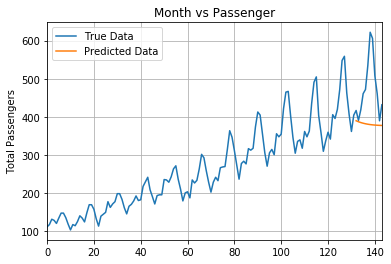

In [28]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_dataset['passengers'])
plt.plot(index,future_passengers)
plt.legend(['True Data','Predicted Data'])
plt.show()

### Reference
https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/